<small><i>This notebook was initially put together by [Jake Vanderplas](http://www.vanderplas.com). Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_tutorial/).</i></small>

Modified by Yuki Saito at 2020.01.20

# SVM(サポートベクターマシン)

Previously we introduced supervised machine learning.
There are many supervised learning algorithms available; here we'll go into brief detail one of the most powerful and interesting methods: **Support Vector Machines (SVMs)**.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
#import seaborn as sns; sns.set()

## SVMの概要と目的

SVMは強力な教理ありクラス分類器の１つです．Classificationのタスクに主に利用されます.

SVMは線形分類器の１種で，データのクラスターに対して境界線(超平面)を決めることでデータを分類します．

/Users/yukisaito/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


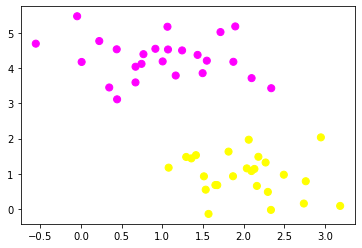

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring');

２セットのデータに対して境界線を引くことを考えましょう．
下の図で分かるように，この問題は制約条件不足(ill-posed)であり様々な境界線が考えられてしまします．


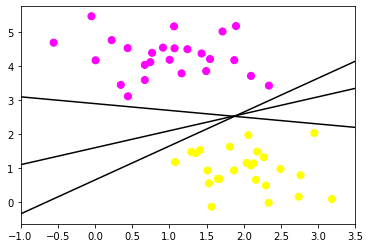

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

### Support Vector Machines: Maximizing the *Margin*

SVMは上記の問題を解決するために，「マージン最大化」と呼ばれる考え方を用います．
マージン最大化とは１データと境界線との間の最短距離(perpendicular distance)を計算し，この距離を全データ分計算した合計の距離が最大になるように境界線を決めるアルゴリズムです．

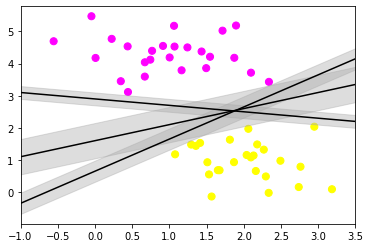

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

このように考えると，上の３つの候補となる境界線の中で，真ん中の境界線がbestな境界線だと決定できます．

#### SVMの学習

以下ではSVMの学習について，コードを解説していきます．


In [6]:
from sklearn.svm import SVC  # "Support Vector Classifier"
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(kernel='linear')

以下のplot図で，SVMの境界線決定関数(decision function)を可視化していきます．

In [7]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

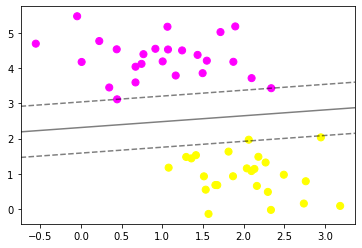

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

Scikit-leaenではsupport_vectors_　attributeの中にサポートベクター(境界線と最も距離が近いデータ点)が記録されています．

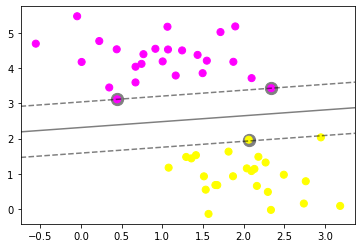

In [9]:
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=150, facecolors= 'grey');
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)


### SVMのパラメータ解説

SVMの最適化に関するパラメータは以下の変数，関数に格納されています．

- clf.coef_ 
- clf.intercept_
- clf.support_
- clf.support_vectors_

**Question** 以下の２つの関数はSVMの最適化の段階の中で何を表している関数でしょうか？Lecture pdfから対応する方程式を探してみてくださいい．


- clf.decision_function(X)
- clf.predict(X)



**ANSWER** Write your answers here

clf.coef_  : 決定境界(超平面)の方程式 h(x) = w0 + XTW の重みW. 
clf.intercept_ : 決定境界(超平面)の方程式 h(x) = w0 + XTW のbias項　w0.
clf.support_ : サポートベクターとなるデータ点のindex値
clf.support_vectors : サポートベクターのデータ点(座標値)



clf.decision_function(X) : 決定境界(超平面)の方程式　　W0 + XTW

clf.predict(X) :  決定境界の方程式を用いて最終的にclassificationの結果となるラベルを与える関数.
                  *yi = +1  if W0 + XTW > 0
                  *yi = -1  if W0 + XTW < 0

#### 応用：カーネル法+SVM

SVMは線形分類器のため,基本的には線形分離可能なデータしかclassificationできません．しかし，現実世界で観測されるデータは大量かつ高次元な複雑なものばかりです．そのため，必ずしも線形分離可能なデータが入力されるとは限らないため上記で説明した線形データのみを想定したSVMはあまり強力なclassifierとは言えません．そこで，非線形データにも対応したSVMを作るために，カーネルトリックと呼ばれる手法を組み合わせます．

カーネルトリックでは入力データに非線形なカーネル関数を与えることで，元のデータをより高次元な非線形空間へと射影します．その結果元々は線形分離不能なデータであっても，線形分離可能なデータへと置換できる　という仮定がカーネル法の概念です．以下で可視化した結果をみていきましょう．


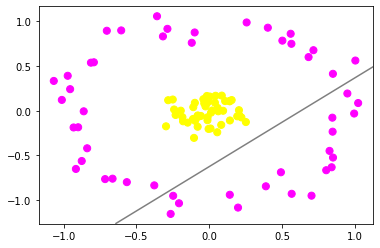

In [10]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

上のように円形に分布指定しているデータは線形分離不能なデータの一例です．
これにカーネル法を適用してみましょう．例えば，カーネル関数として，RBF(radial basis function)関数と呼ばれる非線形関数を適用してみます．

In [11]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

If we plot this along with our data, we can see the effect of it:

In [15]:
from mpl_toolkits import mplot3d
from __future__ import print_function
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

#interact(plot_3D, elev=[-90, 90], azip=(-180, 180));
interact(plot_3D, elev=[-60, -30, 0, 30, 60], azip=(-180, 180));

interactive(children=(Dropdown(description='elev', index=3, options=(-60, -30, 0, 30, 60), value=30), IntSlide…

RBF関数を用いてカーネル法を適用し，SVMでtrainした結果，以下のplot図のように円形分布したデータに対してうまく境界線を引けています．

In [ ]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');